# Search-Based Test Generation - Part 1

In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

import inspect
import ast
import astor

import sys

# For presenting as slides
#plt.rcParams['figure.figsize'] = [12, 8]
#plt.rcParams.update({'font.size': 22})
#plt.rcParams['lines.linewidth'] = 3

## The Test Data Generation Problem

The problem we will consider in this chapter is the following: Given an entry point to a program (a function), we want to find values for the parameters of this function such that the execution of the function reaches a particular point in the program. In other words, we aim to find a test input to the program that covers a target statement. We will then generalise this problem to finding test inputs to cover _all_ statements in the program.

Assume we are aiming to test the following function under test:

In [2]:
def test_me(x, y):
    if x == 2 * (y + 1):
        return True
    else:
        return False

The `test_me` function has two input parameters, `x`and `y`, and it returns `True` or `False` depending on how the parameters relate:

In [3]:
test_me(10, 10)

False

In [4]:
test_me(22, 10)

True

In order to address the test generation problem as a search problem, we need to decide on an encoding, and derive appropriate search operators. It is possible to use bitvectors like we did on previous problems; however, a simpler interpretation of the parameters of a function is a list of the actual parameters. That is, we encode a test input as a list of parameters; we will start by assuming that all parameters are numeric.

The representation for inputs of this function is lists of length two, one element for `x` and one for `y`. As numeric values in Python are unbounded, we need to decide on some finite bounds for these values, e.g.:

In [5]:
MAX = 1000
MIN = -MAX

For generating inputs we can now uniformly sample in the range (MIN, MAX). The length of the vector shall be the number of parameters of the function under test. Rather than hard coding such a parameter, we can also make our approach generalise better by using inspection to determine how many parameters the function under test has:

In [6]:
from inspect import signature
sig = signature(test_me)
num_parameters = len(sig.parameters)
num_parameters

2

As usual, we will define the representation implicitly using a function that produces random instances.

In [7]:
def get_random_individual():
    return [random.randint(MIN, MAX) for _ in range(num_parameters)]

In [8]:
get_random_individual()

[-395, -549]

We need to define search operators matching this representation. To apply local search, we need to define the neighbourhood. For example, we could define one upper and one lower neighbour for each parameter:

- `x-1, y`
- `x+1, y`
- `x, y+1`
- `x, y-1`

In [9]:
def get_neighbours(individual):
    neighbours = []
    for p in range(len(individual)): 
        if individual[p] > MIN:
            neighbour = individual[:]
            neighbour[p] = individual[p] - 1
            neighbours.append(neighbour)
        if individual[p] < MAX:
            neighbour = individual[:]
            neighbour[p] = individual[p] + 1
            neighbours.append(neighbour)
            
    return neighbours

In [10]:
x = get_random_individual()
x

[-960, 316]

In [11]:
get_neighbours(x)

[[-961, 316], [-959, 316], [-960, 315], [-960, 317]]

Before we can apply search, we also need to define a fitness function.  Suppose that we are interested in covering the `True` branch of the if-condition in the `test_me()` function, i.e. `x == 2 * (y + 1)`.

In [12]:
def test_me(x, y):
    if x == 2 * (y + 1):
        return True
    else:
        return False

How close is a given input tuple for this function from reaching the target (true) branch of `x == 2 * (y + 1)`?

Let's consider an arbitrary point in the search space, e.g. `(274, 153)`. The if-condition compares the following values:

In [13]:
x = 274
y = 153
x, 2 * (y + 1)

(274, 308)

In order to make the branch true, both values need to be the same. Thus, the more they differ, the further we are away from making the comparison true, and the less they differ, the closer we are from making the comparison true. Thus, we can quantify "how false" the comparison is by calculating the difference between `x` and `2 * (y + 1)`. Thus, we can calculate this distance as `abs(x - 2 * (y + 1))`:

In [14]:
def calculate_distance(x, y):
    return abs(x - 2 * (y + 1))

In [15]:
calculate_distance(274, 153)

34

We can use this distance value as our fitness function, since we can nicely measure how close we are to an optimal solution. Note, however, that "better" doesn't mean "bigger" in this case; the smaller the distance the better. This is not a problem, since any algorithm that can maximize a value can also be made to minimize it instead.

For each value in the search space of integer tuples, this distance value defines the elevation in our search landscape. Since our example search space is two-dimensional, the search landscape is three-dimensional and we can plot it to see what it looks like:

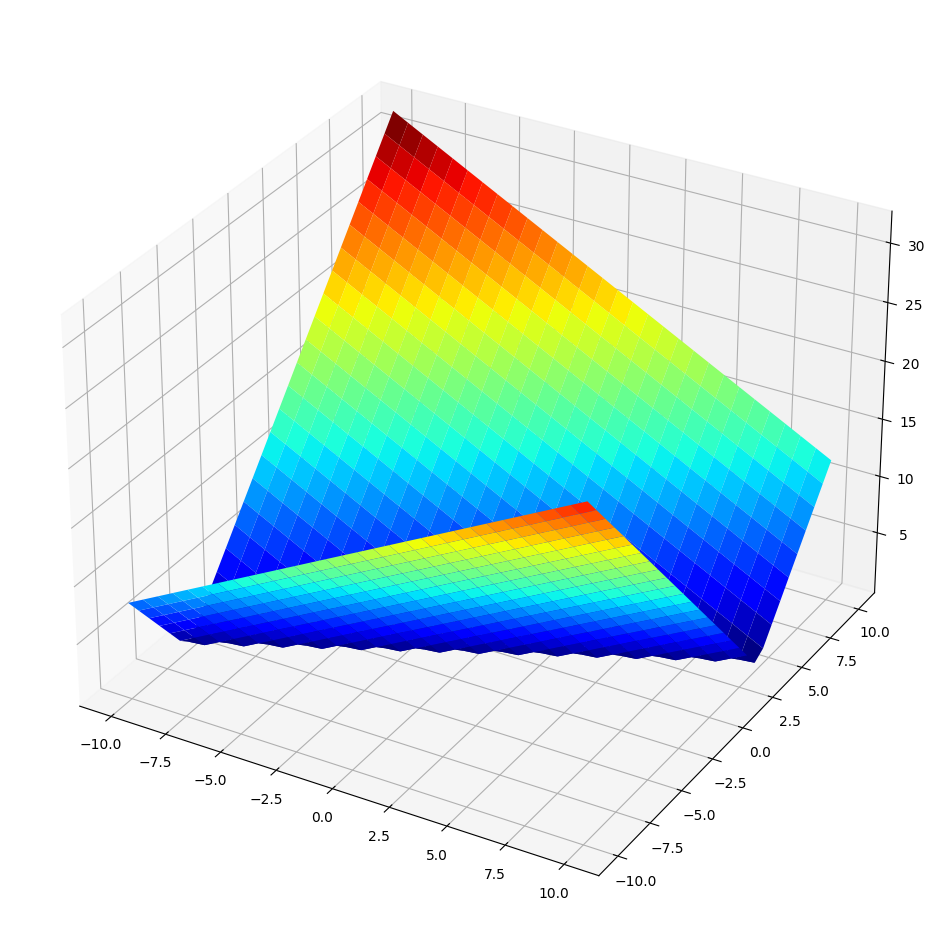

In [16]:
x = np.outer(np.linspace(-10, 10, 30), np.ones(30))
y = x.copy().T
z = calculate_distance(x, y)

fig = plt.figure(figsize=(12, 12))
ax  = plt.axes(projection='3d')

ax.plot_surface(x, y, z, cmap=plt.cm.jet, rstride=1, cstride=1, linewidth=0);

The optimal values, i.e. those that make the if-condition true, have fitness value 0 and can be clearly seen at the bottom of the plot. The further away from the optimal values, the higher elevated the points in the search space.

This distance can serve as our fitness function if we aim to cover the true branch of the program in our example:

In [17]:
def get_fitness(individual):
    x = individual[0]
    y = individual[1]
    return abs(x - 2 * (y + 1))

We can now use any local search algorithm we have defined previously, with only one modification: In the prior examples where we applied local search we were always maximising fitness values; now we are minimising, so a hillclimber, for example, should only move to neighbours with _smaller_ fitness values:

In [18]:
max_steps = 10000
fitness_values = []

Let's use a steepest ascent hillclimber:

In [19]:
def hillclimbing():
    current = get_random_individual()
    fitness = get_fitness(current)
    best, best_fitness = current[:], fitness
    print(f"Starting at fitness {best_fitness}: {best}")

    step = 0
    while step < max_steps and best_fitness > 0:
        neighbours = [(x, get_fitness(x)) for x in get_neighbours(current)]
        best_neighbour, neighbour_fitness = min(neighbours, key=lambda i: i[1])
        step += len(neighbours)        
        fitness_values.extend([best_fitness] * len(neighbours))
        if neighbour_fitness < fitness:
            current = best_neighbour
            fitness = neighbour_fitness
            if fitness < best_fitness:
                best = current[:]
                best_fitness = fitness
        else:
            # Random restart if no neighbour is better
            current = get_random_individual()
            fitness = get_fitness(current)
            step += 1
            if fitness < best_fitness:
                best = current[:]
                best_fitness = fitness
            fitness_values.append(best_fitness)


    print(f"Solution fitness after {step} fitness evaluations: {best_fitness}: {best}")
    return best

In [20]:
max_steps = 10000
fitness_values = []
hillclimbing()

Starting at fitness 1006: [910, -49]
Solution fitness after 2012 fitness evaluations: 0: [910, 454]


[910, 454]

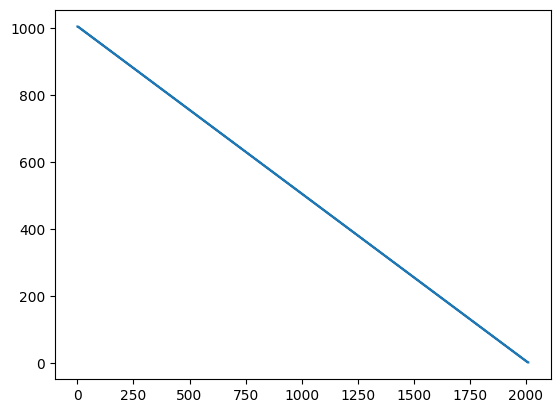

In [21]:
plt.plot(fitness_values)

Since there are no local optima, the hillclimber will easily find the solution, even without restarts. However, this can take a while, in particular if we use a larger input space:

In [22]:
MAX = 100000
MIN = -MAX

Starting at fitness 179321: [74063, -52630]
Solution fitness after 10000 fitness evaluations: 174321: [74063, -50130]


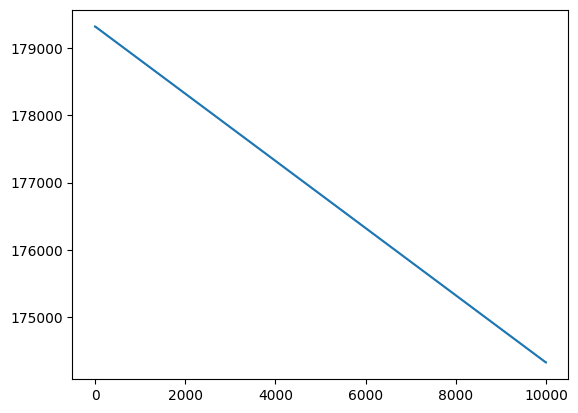

In [23]:
fitness_values = []
hillclimbing()
plt.plot(fitness_values)

Unless the randomly chosen initial point is already close to an optimal solution, the hillclimber is going to be hopeless in moving through the search space within a reasonable number of iterations.

## Alternating Variable Method

The search problem represented by the `test_me` function has an easy fitness landscape with no local optima. However, it still takes quite long to reach the optimum, depending on where the random starting point lies in the search space. This is because the neighbourhood for real program inputs can be quite large, depending on the number of parameters, and even just the search space for each parameter individually can already be very large. In our example we restricted `MAX` and `MIN` to a very narrow range, but imagine doing this for 32 bit integers. Both these problems are addressed with an adapted version of our hillclimber known as the _Alternating Variable Method_, which differs from the hillclimber in two ways: 
1. Rather than considering the neighbourhood of all input parameters at once, we apply search to each parameter individually in turn
2. Rather than taking only small steps of size 1, we allow larger jumps in the search space.

Let's first consider the second aspect, larger jumps in the search space. The idea is to apply a _pattern_ search where we first decide on a direction in the search space to move, and then apply increasingly larger steps in that direction as long as the fitness improves. We only consider a single parameter, thus the "direction" simply refers to whether one increases or decreases this value. The function thus takes (1) the individual on which to perform the search, (2) a particular parameter we are considering, (3) the direction of the search, and (4) the starting fitness values. 

In [24]:
def pattern_search(individual, parameter, direction, fitness):
    print(f"  {individual}, direction {direction}, fitness {fitness}")

    individual[parameter] = individual[parameter] + direction
    new_fitness = get_fitness(individual)
    if new_fitness < fitness:
        fitness_values.append(new_fitness)
        return pattern_search(individual, parameter, 2 * direction, new_fitness)
    else:
        # If fitness is not better we overshot. Undo last move, and return
        fitness_values.append(fitness)
        individual[parameter] = individual[parameter] - direction
        return fitness

For example, let's assume `y` is a large value (1000), and `x` is considerably smaller. For our example function, the optimal value for `x` would thus be at 2200. Applying the search to `x` we thus need to move in the positive direction (`1`), and the function will do this with increasing steps until it "overshoots".

In [25]:
x = [0, 1000]
f = get_fitness(x)
pattern_search(x, 0, 1, get_fitness(x))

  [0, 1000], direction 1, fitness 2002
  [1, 1000], direction 2, fitness 2001
  [3, 1000], direction 4, fitness 1999
  [7, 1000], direction 8, fitness 1995
  [15, 1000], direction 16, fitness 1987
  [31, 1000], direction 32, fitness 1971
  [63, 1000], direction 64, fitness 1939
  [127, 1000], direction 128, fitness 1875
  [255, 1000], direction 256, fitness 1747
  [511, 1000], direction 512, fitness 1491
  [1023, 1000], direction 1024, fitness 979
  [2047, 1000], direction 2048, fitness 45


45

If `x` is larger than `y` we would need to move in the other direction, and the search does this until it undershoots the target of 2200:

In [26]:
x = [10000, 1000]
f = get_fitness(x)
pattern_search(x, 0, -1, get_fitness(x))

  [10000, 1000], direction -1, fitness 7998
  [9999, 1000], direction -2, fitness 7997
  [9997, 1000], direction -4, fitness 7995
  [9993, 1000], direction -8, fitness 7991
  [9985, 1000], direction -16, fitness 7983
  [9969, 1000], direction -32, fitness 7967
  [9937, 1000], direction -64, fitness 7935
  [9873, 1000], direction -128, fitness 7871
  [9745, 1000], direction -256, fitness 7743
  [9489, 1000], direction -512, fitness 7487
  [8977, 1000], direction -1024, fitness 6975
  [7953, 1000], direction -2048, fitness 5951
  [5905, 1000], direction -4096, fitness 3903
  [1809, 1000], direction -8192, fitness 193


193

The AVM algorithm applies the pattern search as follows:
1. Start with the first parameter
2. Probe the neighbourhood of the parameter to find the direction of the search
3. Apply pattern search in that direction
4. Repeat probing + pattern search until no more improvement can be made
5. Move to the next parameter, and go to step 2

Like a regular hillclimber, the search may get stuck in local optima and needs to use random restarts. The algorithm is stuck if it probed all parameters in sequence and none of the parameters allowed a move that improved fitness.

In [27]:
def probe_and_search(individual, parameter, fitness):
    new_parameters = individual[:]
    value = new_parameters[parameter]
    new_fitness = fitness
    # Try +1
    new_parameters[parameter] = individual[parameter] + 1
    print(f"Trying +1 at fitness {fitness}: {new_parameters}")
    new_fitness = get_fitness(new_parameters)
    if new_fitness < fitness:
        fitness_values.append(new_fitness)
        new_fitness = pattern_search(new_parameters, parameter, 2, new_fitness)
    else:
        # Try -1
        fitness_values.append(fitness)
        new_parameters[parameter] = individual[parameter] - 1
        print(f"Trying -1 at fitness {fitness}: {new_parameters}")
        new_fitness = get_fitness(new_parameters)
        if new_fitness < fitness:
            fitness_values.append(new_fitness)
            new_fitness = pattern_search(new_parameters, parameter, -2, new_fitness)
        else:
            fitness_values.append(fitness)
            new_parameters[parameter] = individual[parameter]
            new_fitness = fitness
            
    return new_parameters, new_fitness

In [28]:
def avm():
    current = get_random_individual()
    fitness = get_fitness(current)
    best, best_fitness = current[:], fitness
    fitness_values.append(best_fitness)    
    print(f"Starting at fitness {best_fitness}: {current}")

    changed = True
    while len(fitness_values) < max_steps and best_fitness > 0:
        # Random restart
        if not changed: 
            current = get_random_individual()
            fitness = get_fitness(current)
            fitness_values.append(fitness)
        changed = False
            
        parameter = 0
        while parameter < len(current):
            print(f"Current parameter: {parameter}")
            new_parameters, new_fitness = probe_and_search(current, parameter, fitness)
            if current != new_parameters:
                # Keep on searching
                changed = True
                current = new_parameters
                fitness = new_fitness
                if fitness < best_fitness:
                    best_fitness = fitness
                    best = current[:]
            else:
                parameter += 1

    print(f"Solution fitness {best_fitness}: {best}")
    return best

In [29]:
fitness_values = []
avm()

Starting at fitness 12161: [34073, 10955]
Current parameter: 0
Trying +1 at fitness 12161: [34074, 10955]
Trying -1 at fitness 12161: [34072, 10955]
  [34072, 10955], direction -2, fitness 12160
  [34070, 10955], direction -4, fitness 12158
  [34066, 10955], direction -8, fitness 12154
  [34058, 10955], direction -16, fitness 12146
  [34042, 10955], direction -32, fitness 12130
  [34010, 10955], direction -64, fitness 12098
  [33946, 10955], direction -128, fitness 12034
  [33818, 10955], direction -256, fitness 11906
  [33562, 10955], direction -512, fitness 11650
  [33050, 10955], direction -1024, fitness 11138
  [32026, 10955], direction -2048, fitness 10114
  [29978, 10955], direction -4096, fitness 8066
  [25882, 10955], direction -8192, fitness 3970
Current parameter: 0
Trying +1 at fitness 3970: [25883, 10955]
Trying -1 at fitness 3970: [25881, 10955]
  [25881, 10955], direction -2, fitness 3969
  [25879, 10955], direction -4, fitness 3967
  [25875, 10955], direction -8, fitness

[21912, 10955]

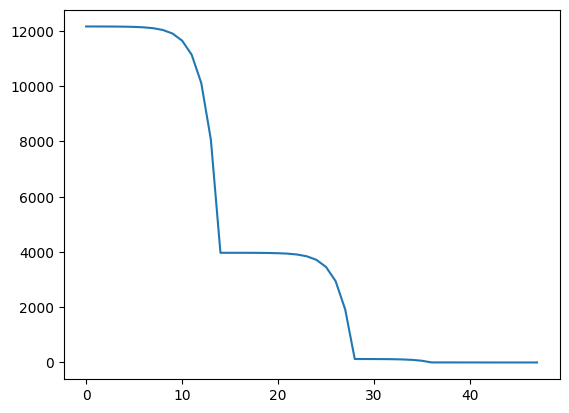

In [30]:
plt.plot(fitness_values)

The pattern search even works efficiently if we increase the size of the search space to 64-bit numbers:

In [31]:
MAX = 2**32
MIN = -MAX

In [32]:
fitness_values = []
avm()

Starting at fitness 3861078628: [2383666104, -738706263]
Current parameter: 0
Trying +1 at fitness 3861078628: [2383666105, -738706263]
Trying -1 at fitness 3861078628: [2383666103, -738706263]
  [2383666103, -738706263], direction -2, fitness 3861078627
  [2383666101, -738706263], direction -4, fitness 3861078625
  [2383666097, -738706263], direction -8, fitness 3861078621
  [2383666089, -738706263], direction -16, fitness 3861078613
  [2383666073, -738706263], direction -32, fitness 3861078597
  [2383666041, -738706263], direction -64, fitness 3861078565
  [2383665977, -738706263], direction -128, fitness 3861078501
  [2383665849, -738706263], direction -256, fitness 3861078373
  [2383665593, -738706263], direction -512, fitness 3861078117
  [2383665081, -738706263], direction -1024, fitness 3861077605
  [2383664057, -738706263], direction -2048, fitness 3861076581
  [2383662009, -738706263], direction -4096, fitness 3861074533
  [2383657913, -738706263], direction -8192, fitness 386

[-1477412524, -738706263]

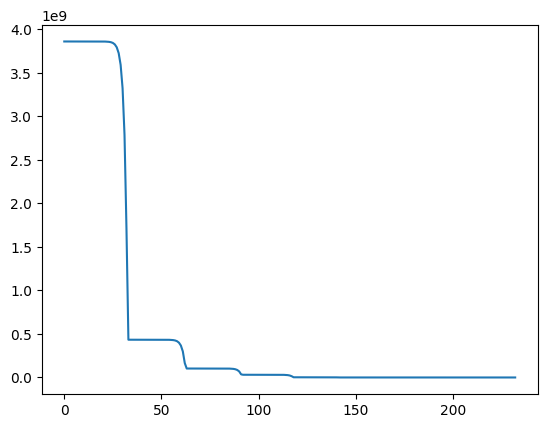

In [33]:
plt.plot(fitness_values)

## Program Instrumentation

Deriving fitness functions is not quite so easy. Of course we could come up with an equation that captures the relation between the sides of the triangle, but then essentially we would need to reproduce the entire program logic again in a function, which certainly does not help generalising to other programs. For example, consider how the fitness function would look like if the comparison was not made on the input parameters, but on values derived through computation within the function under test. Ideally, what we would want is to be able to pick a point in the program and come up with a fitness function automatically that describes how close we are to reaching this point.

There are two central ideas in order to achieve this:

- First, rather than trying to guess how close a program inputs gets to a target statement, we simply _run_ the program with the input and observe how close it actually gets.

- Second, during the execution we keep track of distance estimates like the one we calculated for the `test_me` function whenever we come across conditional statements.

In order to observe what an execution does, we need to *instrument* the program: We add new code immediately before or after the branching condition to keep track of the values observed and calculate the distance using these values.

Let's first consider what is done here conceptually. We first define a global variable in which we will store the distance, so that we can access it after the execution:

In [34]:
distance = 0

Now the instrumented version just has to update the global variable immediately before executing the branching condition:

In [35]:
def test_me_instrumented(x, y):
    global distance
    distance = abs(x - 2 * (y + 1))
    if x == 2 * (y + 1):
        return True
    else:
        return False

Let's try this out for a couple of example values:

In [36]:
test_me_instrumented(0, 0)
distance

2

In [37]:
test_me_instrumented(22, 10)
distance

0

Using this instrumented version of `test_me()`, we can define a fitness function which simply calculates the distance for the condition being true:

In [38]:
def get_fitness(individual):
    global distance
    test_me_instrumented(*individual)
    fitness = distance
    return fitness

Let's try this on some example inputs:

In [39]:
get_fitness([0, 0])

2

When we have reached the target branch, the distance will be 0:

In [40]:
get_fitness([22, 10])

0

When implementing the instrumentation, we need to consider that the branching condition may have side-effects. For example, suppose that the branching condition were `x == 2 * foo(y)`, where `foo()` is a function that takes an integer as input. Naively instrumenting would lead to the following code:

```
    distance = abs(x - 2 * foo(y))
	if x == 2 * foo(y):
	...
```

Thus, the instrumentation would lead to `foo()` being executed *twice*. Suppose `foo()` changes the state of the system (e.g., by printing something, accessing the file system, changing some state variables, etc.), then clearly invoking `foo()` a second time is a bad idea. One way to overcome this problem is to _transform_ the conditions, rather than _adding_ tracing calls. For example, one can create temporary variables that hold the values necessary for the distance calculation and then use these in the branching condition:

```
	tmp1 = x
	tmp2 = 2 * foo(y)
	distance = compute_distance(tmp1, tmp2)
	if tmp1 == tmp2:
	...
```

In [41]:
def evaluate_equals(op1, op2):
    global distance
    distance = abs(op1 - op2)
    if distance == 0:
        return True
    else:
        return False

Now the aim would be to transform the program automatically such that it looks like so:

In [42]:
def test_me_instrumented(x, y):
    tmp1 = x
    tmp2 = 2 * (y + 1)    
    if evaluate_equals(tmp1, tmp2):
        return True
    else:
        return False

Replacing comparisons automatically is actually quite easy in Python, using the abstract syntax tree (AST) of the program. In the AST, a comparison will typically be a tree node with an operator attribute and two children for the left-hand and right-hand operators. To replace such comparisons with a call to `calculate_distance()` one simply needs to replace the comparison node in the AST with a function call node, and this is what the `BranchTransformer` class does using a NodeTransformer from Python's `ast` module:

In [43]:
import ast

In [44]:
class BranchTransformer(ast.NodeTransformer):

    def visit_FunctionDef(self, node):
        node.name = node.name + "_instrumented"
        return self.generic_visit(node)

    def visit_Compare(self, node):
        if not isinstance(node.ops[0], ast.Eq):
            return node

        return ast.Call(func=ast.Name("evaluate_equals", ast.Load()),
                        args=[node.left,
                              node.comparators[0]],
                        keywords=[],
                        starargs=None,
                        kwargs=None)

The `BranchTransformer` parses a target Python program using the built-in parser `ast.parse()`, which returns the AST. Python provides an API to traverse and modify this AST. To replace the comparison with a function call we use an `ast.NodeTransformer`, which uses the visitor pattern where there is one `visit_*` function for each type of node in the AST. As we are interested in replacing comparisons, we override `visit_Compare`, where instead of the original comparison node we return a new node of type `ast.Func`, which is a function call node. The first parameter of this node is the name of the function `calculate_distance`, and the arguments are the two operands that our `calculate_distance` function expects.

You will notice that we also override `visit_FunctionDef`; this is just to change the name of the method by appending `_instrumented`, so that we can continue to use the original function together with the instrumented one.

The following code parses the source code of the `test_me()` function to an AST, then transforms it, and prints it out again (using the `to_source()` function from the `astor` library):

In [45]:
import inspect
import ast
import astor

In [46]:
source = inspect.getsource(test_me)
node = ast.parse(source)
BranchTransformer().visit(node)

# Make sure the line numbers are ok before printing
node = ast.fix_missing_locations(node)
print(astor.to_source(node))

def test_me_instrumented(x, y):
    if evaluate_equals(x, 2 * (y + 1)):
        return True
    else:
        return False



To calculate a fitness value with the instrumented version, we need to compile the instrumented AST again, which is done using Python's `compile()` function. We then need to make the compiled function accessible, for which we first retrieve the current module from `sys.modules`, and then add the compiled code of the instrumented function to the list of functions of the current module using `exec`. After this, the `cgi_decode_instrumented()` function can be accessed.

In [47]:
import sys

In [48]:
def create_instrumented_function(f):
    source = inspect.getsource(f)
    node = ast.parse(source)
    node = BranchTransformer().visit(node)

    # Make sure the line numbers are ok so that it compiles
    node = ast.fix_missing_locations(node)

    # Compile and add the instrumented function to the current module
    current_module = sys.modules[__name__]
    code = compile(node, filename="<ast>", mode="exec")
    exec(code, current_module.__dict__)

In [49]:
create_instrumented_function(test_me)

In [50]:
test_me_instrumented(0, 0)

False

In [51]:
distance

2

In [52]:
test_me_instrumented(22, 10)

True

In [53]:
distance

0

The estimate for any relational comparison of two values is defined in terms of the _branch distance_. Our `evaluate_equals` function indeed implements the branch distance function for an equality comparison. To generalise this we need similar estimates for other types of relational comparisons. Furthermore, we also have to consider the distance to such conditions evaluating to false, not just to true. Thus, each if-condition actually has two distance estimates, one to estimate how close it is to being true, and one how close it is to being false. If the condition is true, then the true distance is 0; if the condition is false, then the false distance is 0. That is, in a comparison `a == b`, if `a` is smaller than `b`, then the false distance is `0` by definition. 

The following table shows how to calculate the distance for different types of comparisons:

| Condition | Distance True | Distance False |
| ------------- |:-------------:| -----:|
| a == b      | abs(a - b) | 1 |
| a != b      | 1          | abs(a - b) |
| a < b       | b - a + 1  | a - b      |
| a <= b      | b - a      | a - b + 1  |
| a > b       | a - b + 1  | b - a      |


Note that several of the calculations add a constant `1`. The reason for this is quite simple: Suppose we want to have `a < b` evaluate to true, and let `a = 27` and `b = 27`. The condition is not true, but simply taking the difference would give us a result of `0`. To avoid this, we have to add a constant value. It is not important whether this value is `1` -- any positive constant works.

We generalise our `evaluate_equals` function to an `evaluate_condition` function that takes the operator as an additional parameter, and then implements the above table. In contrast to the previous `calculate_equals`, we will now calculate both, the true and the false distance:

In [54]:
def evaluate_condition(op, lhs, rhs):
    distance_true = 0
    distance_false = 0
    if op == "Eq":
        if lhs == rhs:
            distance_false = 1
        else:
            distance_true = abs(lhs - rhs)

    # ... code for other types of conditions

    if distance_true == 0:
        return True
    else:
        return False

Let's consider a slightly larger function under test. We will use the well known triangle example, originating in Glenford Meyer's classical Art of Software Testing book 

In [55]:
def triangle(a, b, c):
    if a <= 0 or b <= 0 or c <= 0:
        return 4 # invalid
    
    if a + b <= c or a + c <= b or b + c <= a:
        return 4 # invalid
    
    if a == b and b == c:
        return 1 # equilateral
    
    if a == b or b == c or a == c:
        return 2 # isosceles
    
    return 3 # scalene

The function takes as input the length of the three sides of a triangle, and returns a number representing the type of triangle:

In [56]:
triangle(4,4,4)

1

Adapting our representation is easy, we just need to correctly set the number of parameters:

In [57]:
sig = signature(triangle)
num_parameters = len(sig.parameters)
num_parameters

3

For the `triangle` function, however, we have multiple if-conditions; we have to add instrumentation to each of these using `evaluate_condition`. We also need to generalise from our global `distance` variable, since we now have two distance values per branch, and potentially multiple branches. Furthermore, a condition might be executed multiple times within a single execution (e.g., if it is in a loop), so rather than storing all values, we will only keep the _minimum_ value observed for each condition:

In [58]:
distances_true = {}
distances_false = {}

In [59]:
def update_maps(condition_num, d_true, d_false):
    global distances_true, distances_false

    if condition_num in distances_true.keys():
        distances_true[condition_num] = min(distances_true[condition_num], d_true)
    else:
        distances_true[condition_num] = d_true

    if condition_num in distances_false.keys():
        distances_false[condition_num] = min(distances_false[condition_num], d_false)
    else:
        distances_false[condition_num] = d_false

Now we need to finish implementing the `evaluate_condition` function. We add yet another parameter to denote the ID of the branch we are instrumenting:

In [60]:
def evaluate_condition(num, op, lhs, rhs):
    distance_true = 0
    distance_false = 0

    # Make sure the distance can be calculated on number and character
    # comparisons (needed for cgi_decode later)
    if isinstance(lhs, str):
        lhs = ord(lhs)
    if isinstance(rhs, str):
        rhs = ord(rhs)

    if op == "Eq":
        if lhs == rhs:
            distance_false = 1
        else:
            distance_true = abs(lhs - rhs)

    elif op == "Gt":
        if lhs > rhs:
            distance_false = lhs - rhs
        else:
            distance_true = rhs - lhs + 1
    elif op == "Lt":
        if lhs < rhs:
            distance_false = rhs - lhs
        else:
            distance_true = lhs - rhs + 1
    elif op == "LtE":
        if lhs <= rhs:
            distance_false = rhs - lhs + 1
        else:
            distance_true = lhs - rhs
    # ...
    # handle other comparison operators
    # ...

    elif op == "In":
        minimum = sys.maxsize
        for elem in rhs.keys():
            distance = abs(lhs - ord(elem))
            if distance < minimum:
                minimum = distance

        distance_true = minimum
        if distance_true == 0:
            distance_false = 1
    else:
        assert False

    update_maps(num, normalise(distance_true), normalise(distance_false))

    if distance_true == 0:
        return True
    else:
        return False

We need to normalise branch distances since different comparisons will be on different scales, and this would bias the search. We will use the normalisaction function defined in the previous chapter:

In [61]:
def normalise(x):
    return x / (1.0 + x)

We also need to extend our instrumentation function to take care of all comparisons, and not just equality comparisons:

In [62]:
import ast
class BranchTransformer(ast.NodeTransformer):

    branch_num = 0

    def visit_FunctionDef(self, node):
        node.name = node.name + "_instrumented"
        return self.generic_visit(node)

    def visit_Compare(self, node):
        if node.ops[0] in [ast.Is, ast.IsNot, ast.In, ast.NotIn]:
            return node

        self.branch_num += 1
        return ast.Call(func=ast.Name("evaluate_condition", ast.Load()),
                        args=[ast.Num(self.branch_num - 1),
                              ast.Str(node.ops[0].__class__.__name__),
                              node.left,
                              node.comparators[0]],
                        keywords=[],
                        starargs=None,
                        kwargs=None)

We can now take a look at the instrumented version of `triangle`:

In [63]:
source = inspect.getsource(triangle)
node = ast.parse(source)
transformer = BranchTransformer()
transformer.visit(node)

# Make sure the line numbers are ok before printing
node = ast.fix_missing_locations(node)
num_branches = transformer.branch_num

print(astor.to_source(node))

def triangle_instrumented(a, b, c):
    if evaluate_condition(0, 'LtE', a, 0) or evaluate_condition(1, 'LtE', b, 0
        ) or evaluate_condition(2, 'LtE', c, 0):
        return 4
    if evaluate_condition(3, 'LtE', a + b, c) or evaluate_condition(4,
        'LtE', a + c, b) or evaluate_condition(5, 'LtE', b + c, a):
        return 4
    if evaluate_condition(6, 'Eq', a, b) and evaluate_condition(7, 'Eq', b, c):
        return 1
    if evaluate_condition(8, 'Eq', a, b) or evaluate_condition(9, 'Eq', b, c
        ) or evaluate_condition(10, 'Eq', a, c):
        return 2
    return 3



To define an executable version of the instrumented triangle function, we can use our `create_instrumented_function` function again:

In [64]:
create_instrumented_function(triangle)

In [65]:
triangle_instrumented(4, 4, 4)

1

In [66]:
distances_true

{0: 0.8, 1: 0.8, 2: 0.8, 3: 0.8, 4: 0.8, 5: 0.8, 6: 0.0, 7: 0.0}

In [67]:
distances_false

{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.5, 7: 0.5}

The branch distance functions above are defined only for atomic comparisons. However, in the `triangle` program all of the atomic comparisons are part of larger predicates, joined together by `and` and `or` connectors. 

For conjunctions the branch distance is defined such that the distance to make `A and B` true equals the sum of the branch distances for `A` and `B`, as both of the two conditions would need to be true. Similarly, the branch distance to make `A or B` true would be the _minimum_ of the two branch distances of `A` and `B`, as it suffices if one of the two conditions is true to make the entire expression true (and the false distance would be the sum of false distances of the conditions). For a negation `not A`, we can simply switch from the true distance to the false distance, or vice versa. Since predicates can consist of nested conditions, one would need to recursively calculate the branch distance.


Assume we want to find an input that covers the third if-condition, i.e., it produces a triangle where all sides have equal length. Considering the instrumented version of the triangle function we printed above, in order for this if-condition to evaluate to true we require conditions 0, 1, 2, 3, 4, and 5 to evaluate to false, and 6 and 7 to evaluate to true. Thus, the fitness function for this branch would be the sum of false distances for branches 0-5, and true distances for branches 6 and 7.

In [68]:
def get_fitness(x):
    # Reset any distance values from previous executions
    global distances_true, distances_false
    distances_true  = {x: 1.0 for x in range(num_branches)}
    distances_false = {x: 1.0 for x in range(num_branches)}

    # Run the function under test
    triangle_instrumented(*x)

    # Sum up branch distances for our specific target branch
    fitness = 0.0
    for branch in [6, 7]:
        fitness += distances_true[branch]

    for branch in [0, 1, 2, 3, 4, 5]:
        fitness += distances_false[branch]

    return fitness

In [69]:
get_fitness([5,5,5])

0.0

In [70]:
get_fitness(get_random_individual())

1.9999999994312394

In [71]:
MAX = 10000
MIN = -MAX
fitness_values = []
max_gen = 1000
hillclimbing()

Starting at fitness 7.99009900990099: [-99, 1534, -8014]
Solution fitness after 10002 fitness evaluations: 5.9998449371995655: [1, 1534, -6447]


[1, 1534, -6447]

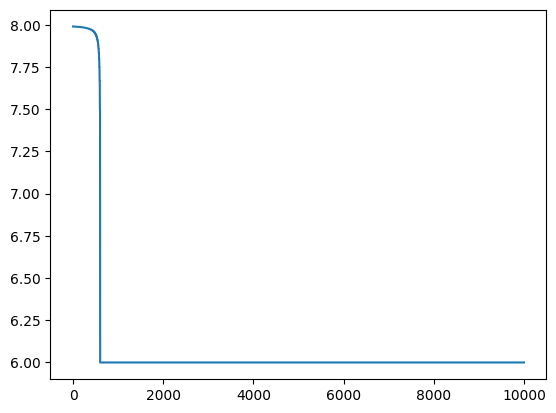

In [72]:
plt.plot(fitness_values)

In [73]:
fitness_values = []
avm()

Starting at fitness 6.999708114419148: [6710, -3424, -6516]
Current parameter: 0
Trying +1 at fitness 6.999708114419148: [6711, -3424, -6516]
Trying -1 at fitness 6.999708114419148: [6709, -3424, -6516]
Current parameter: 1
Trying +1 at fitness 6.999708114419148: [6710, -3423, -6516]
  [6710, -3423, -6516], direction 2, fitness 6.99970802919708
  [6710, -3421, -6516], direction 4, fitness 6.999707858603564
  [6710, -3417, -6516], direction 8, fitness 6.999707516817783
  [6710, -3409, -6516], direction 16, fitness 6.999706830841395
  [6710, -3393, -6516], direction 32, fitness 6.999705449189985
  [6710, -3361, -6516], direction 64, fitness 6.999702646446625
  [6710, -3297, -6516], direction 128, fitness 6.99969687784177
  [6710, -3169, -6516], direction 256, fitness 6.999684642068749
  [6710, -2913, -6516], direction 512, fitness 6.999656946826758
  [6710, -2401, -6516], direction 1024, fitness 6.999583853516437
  [6710, -1377, -6516], direction 2048, fitness 6.999274836838289
  [6710, 

[5611, 5611, 5611]

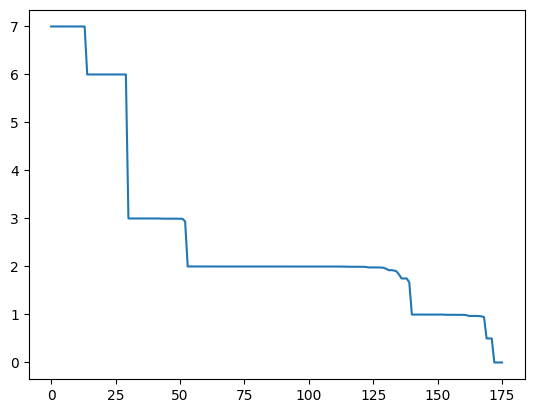

In [74]:
plt.plot(fitness_values)

Besides the local search algorithms, we can also use evolutionary search in order to find solutions to our test generation problem. We therefore need to define the usual search operators:

In [75]:
tournament_size = 3
def tournament_selection(population):
    candidates = random.sample(population, tournament_size)        
    winner = min(candidates, key = lambda x: get_fitness(x))
    return winner

In [76]:
elite_size = 2
def elitism_standard(population):
    population.sort(key = lambda k: get_fitness(k))
    return population[:elite_size]

In [77]:
def mutate(solution):
    P_mutate = 1/len(solution)
    mutated = solution[:]
    for position in range(len(solution)):
        if random.random() < P_mutate:
            mutated[position] = int(random.gauss(mutated[position], 20))
    return mutated

In [78]:
def singlepoint_crossover(parent1, parent2):
    pos = random.randint(0, len(parent1))
    offspring1 = parent1[:pos] + parent2[pos:]
    offspring2 = parent2[:pos] + parent1[pos:]
    return (offspring1, offspring2)

In [79]:
population_size = 20
P_xover = 0.7
max_gen = 100
selection = tournament_selection
crossover = singlepoint_crossover
elitism = elitism_standard
MAX = 1000
MIN = -MAX

In [80]:
def ga():
    population = [get_random_individual() for _ in range(population_size)]
    best_fitness = sys.maxsize
    for p in population:
        fitness = get_fitness(p)
        if fitness < best_fitness:
            best_fitness = fitness
            best_solution = p
    print(f"Iteration 0, best fitness: {best_fitness}")

    for iteration in range(max_gen):
        fitness_values.append(best_fitness)
        new_population = elitism(population)
        while len(new_population) < len(population):
            parent1 = selection(population)
            parent2 = selection(population)

            if random.random() < P_xover:
                offspring1, offspring2 = crossover(parent1, parent2)
            else:
                offspring1, offspring2 = parent1, parent2

            offspring1 = mutate(offspring1)
            offspring2 = mutate(offspring2)
            
            new_population.append(offspring1)
            new_population.append(offspring2)

        population = new_population
        for p in population:
            fitness = get_fitness(p)
            if fitness < best_fitness:
                best_fitness = fitness
                best_solution = p
        print(f"Iteration {iteration}, best fitness: {best_fitness}, size {len(best_solution)}")

    return best_solution

In [81]:
fitness_values = []
ga()

Iteration 0, best fitness: 1.9974424552429668
Iteration 0, best fitness: 1.9850746268656716, size 3
Iteration 1, best fitness: 1.981818181818182, size 3
Iteration 2, best fitness: 1.973684210526316, size 3
Iteration 3, best fitness: 1.9375, size 3
Iteration 4, best fitness: 1.5, size 3
Iteration 5, best fitness: 1.5, size 3
Iteration 6, best fitness: 0.9807692307692307, size 3
Iteration 7, best fitness: 0.9807692307692307, size 3
Iteration 8, best fitness: 0.9807692307692307, size 3
Iteration 9, best fitness: 0.9807692307692307, size 3
Iteration 10, best fitness: 0.9807692307692307, size 3
Iteration 11, best fitness: 0.9736842105263158, size 3
Iteration 12, best fitness: 0.96, size 3
Iteration 13, best fitness: 0.96, size 3
Iteration 14, best fitness: 0.9545454545454546, size 3
Iteration 15, best fitness: 0.6666666666666666, size 3
Iteration 16, best fitness: 0.5, size 3
Iteration 17, best fitness: 0.5, size 3
Iteration 18, best fitness: 0.5, size 3
Iteration 19, best fitness: 0.5, siz

[834, 834, 834]

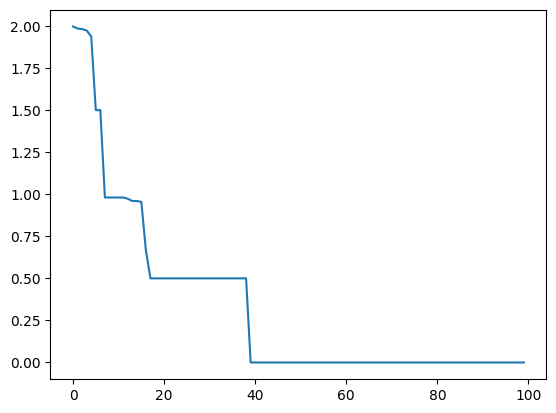

In [82]:
plt.plot(fitness_values)

We set `MAX` to a value as low as 1000, because the optimisation with our small mutational steps may take long to achieve that multiple values are equal, which some of the branches of the triangle program require (such as the one we are optimising for currently).

Iteration 0, best fitness: 1.9999718381255458
Iteration 0, best fitness: 1.9999718301923997, size 3
Iteration 1, best fitness: 1.9999428669370967, size 3
Iteration 2, best fitness: 1.9999428669370967, size 3
Iteration 3, best fitness: 1.9999427295114827, size 3
Iteration 4, best fitness: 1.9999426769848094, size 3
Iteration 5, best fitness: 1.9999425848309125, size 3
Iteration 6, best fitness: 1.9999425485464783, size 3
Iteration 7, best fitness: 1.9999424261615522, size 3
Iteration 8, best fitness: 1.9999423398489304, size 3
Iteration 9, best fitness: 1.9999422766104824, size 3
Iteration 10, best fitness: 1.9999422766104824, size 3
Iteration 11, best fitness: 1.9999422199110186, size 3
Iteration 12, best fitness: 1.99994209612044, size 3
Iteration 13, best fitness: 1.9999419886297716, size 3
Iteration 14, best fitness: 1.9999419077495062, size 3
Iteration 15, best fitness: 1.9999418841169292, size 3
Iteration 16, best fitness: 1.9999418063314711, size 3
Iteration 17, best fitness: 1.9

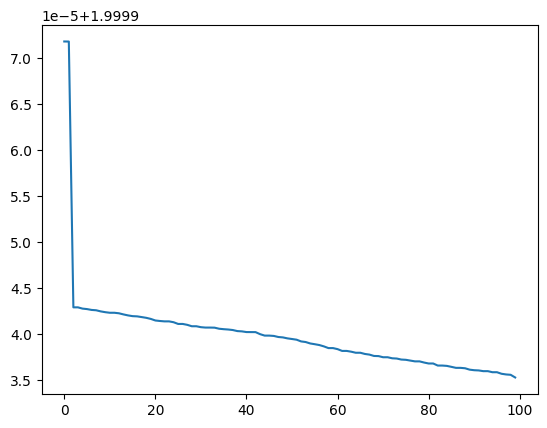

In [83]:
MAX = 100000
MIN = -MAX
fitness_values = []
ga()
plt.plot(fitness_values)

Different mutation operators may yield different results: For example, rather than just adding random noise to the individual parameters, we can also probabilistically copy values from other parameters:

In [84]:
def mutate(solution):
    P_mutate = 1/len(solution)
    mutated = solution[:]
    for position in range(len(solution)):
        if random.random() < P_mutate:
            if random.random() < 0.9:
                mutated[position] = int(random.gauss(mutated[position], 20))
            else:
                mutated[position] = random.choice(solution)
    return mutated

Let's see the performance of the resulting algorithm:

In [85]:
fitness_values = []
MAX = 100000
MIN = -MAX
ga()

Iteration 0, best fitness: 1.9997491219267436
Iteration 0, best fitness: 1.9997491219267436, size 3
Iteration 1, best fitness: 1.9997491219267436, size 3
Iteration 2, best fitness: 1.9997481108312343, size 3
Iteration 3, best fitness: 1.9997469635627532, size 3
Iteration 4, best fitness: 1.999746771334515, size 3
Iteration 5, best fitness: 0.9999531681730904, size 3
Iteration 6, best fitness: 0.9999531506207543, size 3
Iteration 7, best fitness: 0.999953119872486, size 3
Iteration 8, best fitness: 0.999953119872486, size 3
Iteration 9, best fitness: 0.999942624361696, size 3
Iteration 10, best fitness: 0.999942624361696, size 3
Iteration 11, best fitness: 0.9999426210695432, size 3
Iteration 12, best fitness: 0.0, size 3
Iteration 13, best fitness: 0.0, size 3
Iteration 14, best fitness: 0.0, size 3
Iteration 15, best fitness: 0.0, size 3
Iteration 16, best fitness: 0.0, size 3
Iteration 17, best fitness: 0.0, size 3
Iteration 18, best fitness: 0.0, size 3
Iteration 19, best fitness: 0

[61199, 61199, 61199]

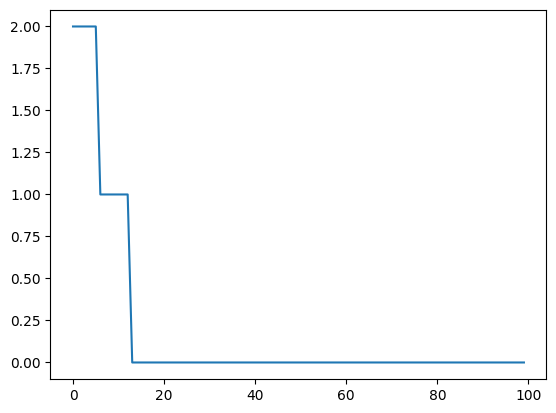

In [86]:
plt.plot(fitness_values)

In our fitness function, we manually determined which branches need to evaluate which way, and how to sum up the fitness functions. In practice, this can be automated by combining the branch distance metric with the _approach level_, which was introduced (originally named approximation level) in this paper:

Wegener, J., Baresel, A., & Sthamer, H. (2001). Evolutionary test environment for automatic structural testing. Information and software technology, 43(14), 841-854.

The approach level calculates the distances of an execution from a target node in terms of graph distances on the control dependence graph. However, we will not cover the approach level in this chapter.

## Whole Test Suite Optimisation

Besides the question of how the best fitness function for a coverage goal looks like, there are some related questions: How much time should we spend on optimising for each coverage goal? It is possible that some coverage goals are infeasible (e.g., dead code, or or infeasible branches), so any time spent on these is wasted, while it may be missing for other goals that are feasible but would need more time. Test cases typically cover multiple goals at the same time; even if a test is optimised for one specific line or branch, it may coincidentally cover others along the execution. Thus, the order in which we select coverage goals for optimisation may influence the overall result, and the number of tests we require. In principle, one way to address these issues would be by casting test generation as a multi-objective optimisation problem, and aiming to produce tests for _all_ coverage goals at the same time. However, there is an issue with this: Multi-objective algorithms like the ones we considered in the previous chapter typically work well on 2-3 objectives, but code will generally have many more coverage objectives, rendering classical multi-objective algorithms infeasible (Pareto-dominance happens rarely with higher numbers of objectives). We will therefore now consider some alternatives.

The first alternative we consider is to switch our representation: Rather than optimising individual test cases for individual coverage objectives, we optimise entire test _suites_ to cover _all_ coverage objectives at the same time. Our encoding thus should describe multiple tests. But how many? This is very much problem specific. Thus, rather than hard coding the number of tests, we will only define an upper bound, and let the search decide what is the necessary number of tests.

In [87]:
num_tests = 30

In [88]:
def get_random_individual():
    num = random.randint(1, num_tests)
    return [[random.randint(MIN, MAX) for _ in range(num_parameters)] for _ in range(num)]

When applying mutation, we need to be able to modify individual tests as before. To keep things challenging, we will not use our optimised mutation that copies parameters, but aim to achieve the entire optimisation just using small steps:

In [89]:
def mutate_test(solution):
    P_mutate = 1/len(solution)
    mutated = solution[:]
    for position in range(len(solution)):
        if random.random() < P_mutate:
            mutated[position] = min(MAX, max(MIN, int(random.gauss(mutated[position], MAX*0.01))))
            
    return mutated

However, modifying tests is only one of the things we can do when mutating our actual individuals, which consist of multiple tests. Besides modifying existing tests, we could also delete or add tests, for example like this.

In [90]:
def mutate_set(solution):
    P_mutate = 1/len(solution)
    mutated = []
    for position in range(len(solution)):
        if random.random() >= P_mutate:
            mutated.append(solution[position][:])
            
    if not mutated:
        mutated = solution[:]
    for position in range(len(mutated)):
        if random.random() < P_mutate:
            mutated[position] = mutate_test(mutated[position])
 
    ALPHA = 1/3
    count = 1
    while random.random() < ALPHA ** count:
        count += 1
        mutated.append([random.randint(MIN, MAX) for _ in range(num_parameters)])
    
    return mutated

With a certain probability, each of the tests can be removed from a test suite; similarly, each remaining test may be mutated like we mutated tests previously. Finally, with a probability `ALPHA` we insert a new test; if we do so, we insert another one with probability `ALPHA`$^2$, and so on.

When crossing over two individuals, they might have different length, which makes choosing a crossover point difficult. For example, we might pick a crossover point that is longer than one of the parent chromosomes, and then what do we do? A simple solution would be to pick two different crossover points.

In [91]:
def variable_crossover(parent1, parent2):
    pos1 = random.randint(1, len(parent1))
    pos2 = random.randint(1, len(parent2))
    offspring1 = parent1[:pos1] + parent2[pos2:]
    offspring2 = parent2[:pos2] + parent1[pos1:]
    return (offspring1, offspring2)

To see this works, we need to define the fitness function. Since we want to cover _everything_ we simply need to make sure that every single branch is covered at least once in a test suite. A branch is covered if its minimum branch distance is 0; thus, if everything is covered, then the sum of minimal branch distances should be 0.

There is one special case: If an if-statement is executed only once, then optimising the true/false distance may lead to a suboptimal, oscillising evolution. We therefore also count how often each if-condition was executed. If it was only executed once, then the fitness value for that branch needs to be higher than if it was executed twice. For this, we extend our `update_maps` function to also keep track of the execution count:

In [92]:
condition_count = {}
def update_maps(condition_num, d_true, d_false):
    global distances_true, distances_false, condition_count

    if condition_num in condition_count.keys():
        condition_count[condition_num] = condition_count[condition_num] + 1
    else:
        condition_count[condition_num] = 1
        
    if condition_num in distances_true.keys():
        distances_true[condition_num] = min(
            distances_true[condition_num], d_true)
    else:
        distances_true[condition_num] = d_true

    if condition_num in distances_false.keys():
        distances_false[condition_num] = min(
            distances_false[condition_num], d_false)
    else:
        distances_false[condition_num] = d_false

The actual fitness function now is the sum of minimal distances after all tests have been executed. If an if-condition was not executed at all, then the true distance and the false distance will be 1, resulting in a sum of 2 for the if-condition. If the condition was covered only once, we set the fitness to exactly 1. If the condition was executed more than once, then at least either the true or false distance has to be 0, such that in sum, true and false distances will be less than 0.

In [93]:
def get_fitness(x):
    # Reset any distance values from previous executions
    global distances_true, distances_false, condition_count
    distances_true =  {x: 1.0 for x in range(num_branches)}
    distances_false = {x: 1.0 for x in range(num_branches)}
    condition_count = {x:   0 for x in range(num_branches)}

    # Run the function under test
    for test in x:
        triangle_instrumented(*test)

    # Sum up branch distances
    fitness = 0.0
    for branch in range(num_branches):
        if condition_count[branch] == 1:
            fitness += 1
        else:
            fitness += distances_true[branch]
            fitness += distances_false[branch]

    return fitness

Before we run some experiments on this, let's make a small addition to our genetic algorithm: Since the size of individuals is variable it will be interesting to observe how this evolves. We'll captures the average population size in a separate list. Since the costs of evaluating fitness are no longer constant per individual but depend on the number of tests executed, we will also change our stopping criterion to the number of executed tests.

In [94]:
from statistics import mean

length_values = []
max_executions = 10000

def ga():
    population = [get_random_individual() for _ in range(population_size)]
    best_fitness = sys.maxsize
    tests_executed = 0
    for p in population:
        fitness = get_fitness(p)
        tests_executed += len(p)
        if fitness < best_fitness:
            best_fitness = fitness
            best_solution = p
    while tests_executed < max_executions:
        fitness_values.append(best_fitness)
        length_values.append(mean([len(x) for x in population]))
        new_population = elitism(population)
        while len(new_population) < len(population):
            parent1 = selection(population)
            parent2 = selection(population)

            if random.random() < P_xover:
                offspring1, offspring2 = crossover(parent1, parent2)
            else:
                offspring1, offspring2 = parent1, parent2

            offspring1 = mutate(offspring1)
            offspring2 = mutate(offspring2)
            
            new_population.append(offspring1)
            new_population.append(offspring2)
            tests_executed += len(offspring1) + len(offspring2)

        population = new_population
        for p in population:
            fitness = get_fitness(p)
            if fitness < best_fitness:
                best_fitness = fitness
                best_solution = p
    print(f"Best fitness: {best_fitness}, size {len(best_solution)}")

    return best_solution

Since we now have all the operators we need in place, let's run a first experiment aiming to achieve 100% coverage on the triangle example.

In [95]:
max_executions = 1000000
MAX = 1000
MIN = -MAX
crossover = variable_crossover
selection = tournament_selection
elitism   = elitism_standard 
mutate    = mutate_set
tournament_size = 4
population_size = 50
fitness_values = []
length_values = []
ga()

Best fitness: 1.6639928698752229, size 599


[[163, -456, 599],
 [-959, -679, -410],
 [-250, -937, -311],
 [-714, -221, 291],
 [-671, -292, 622],
 [755, 79, 171],
 [-957, 728, 850],
 [601, 675, 129],
 [850, 829, -838],
 [955, -584, 306],
 [349, -307, 662],
 [-627, -999, 506],
 [423, 738, 207],
 [697, -759, 433],
 [-316, -826, 245],
 [38, -736, 465],
 [-358, 699, 200],
 [248, 602, 104],
 [606, -133, 946],
 [255, 330, 335],
 [-376, 687, 192],
 [200, -899, 422],
 [442, 441, 802],
 [-849, 683, 601],
 [731, -183, 721],
 [931, -847, 953],
 [682, -346, -440],
 [-117, -105, -443],
 [218, 49, 531],
 [-733, 183, -990],
 [939, 3, 325],
 [64, 737, 522],
 [237, 530, -62],
 [-559, -615, -926],
 [-839, 129, 274],
 [211, 671, -877],
 [120, -431, -259],
 [261, 333, 335],
 [-358, 699, 186],
 [200, -899, 422],
 [442, 441, 802],
 [931, -849, 960],
 [682, -346, -440],
 [-117, -105, -443],
 [218, 49, 531],
 [-733, 183, -990],
 [692, -92, -503],
 [64, 737, 522],
 [237, 530, -62],
 [-839, 129, 274],
 [120, -431, -259],
 [323, -379, -684],
 [-884, -628, 

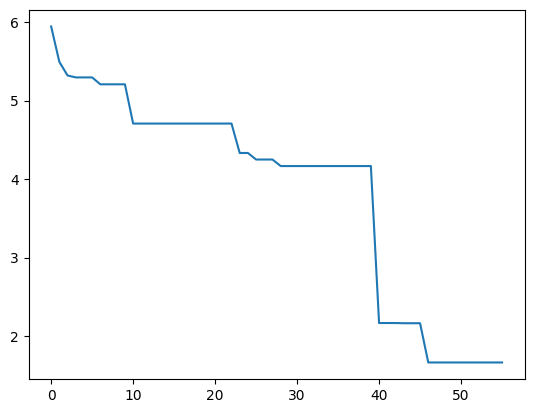

In [96]:
plt.plot(fitness_values)

The plot shows iterations of the genetic algorithm on the x-axis. Very likely, the result likely isn't great. But why? Let's look at the average population length.

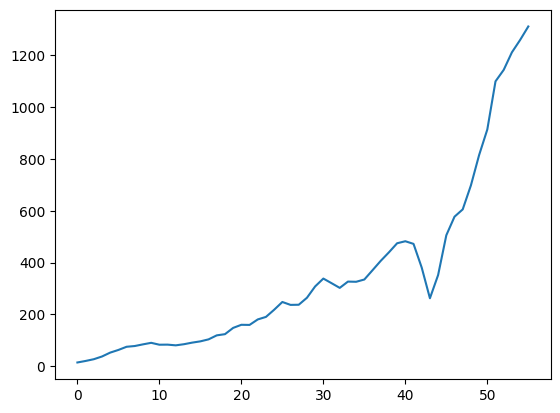

In [97]:
plt.plot(length_values)

What you can see here is a phenomenon called _bloat_: Individuals grow in size through mutation and crossover, and the search has no incentive to reduce their size (adding a test can never decrease coverage; removing a test can). As a result the individuals just keep growing, and quickly eat up all the available resources for the search. How to deal with this problem will be covered in the next chapter.